In [ ]:
!pip install scikit-learn==1.0.2
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Preprocessing

We will load the Boston housing dataset and split it into training and testing datasets. Then, we'll standardize the features, as SVM is sensitive to feature scaling.

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Boston housing dataset
boston = load_boston()
X, y = boston.data, boston.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((404, 13), (102, 13))

We've successfully loaded the Boston housing dataset and preprocessed it. The training set consists of 404 samples, and the testing set consists of 102 samples. Each sample has 13 features.

## Baseline SVM Model

Training a Support Vector Regression (SVR) model on the training set and evaluating its performance on the test set.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Train a baseline SVR model
baseline_svr = SVR()
baseline_svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_baseline = baseline_svr.predict(X_test_scaled)

# Compute the mean squared error and R^2 score for the baseline model
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

mse_baseline, r2_baseline


(25.66853967839608, 0.649976605976003)

#### For the baseline SVR model:



*   Mean Squared Error (MSE): 25.67
*   R2 Score: 0.65

The R2 score indicates that our baseline SVR model can explain approximately 65% of the variance in the target variable.



## SVM with Cross-Validation
We will now train our SVR model using cross-validation and compute the mean accuracy (R^2 score) across all the folds.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the SVR model
cross_val_r2_scores = cross_val_score(SVR(), X_train_scaled, y_train, cv=5, scoring='r2')

# Compute mean and standard deviation of R^2 scores
mean_cross_val_r2 = cross_val_r2_scores.mean()
std_cross_val_r2 = cross_val_r2_scores.std()

mean_cross_val_r2, std_cross_val_r2


(0.6268468169134396, 0.035057700956748705)

#### Using cross-validation on the SVR model, we get:



*   Mean R2 Score): 0.627
*   Standard Deviation of R2 Scores: 0.035

The mean R2 score is quite similar to our baseline model. The standard deviation indicates the variability in the R2 scores across different folds.



## Hyperparameter Tuning
For hyperparameter tuning, we will use grid search with cross-validation to find the best hyperparameters for the SVR. We'll tune the C (regularization parameter) and gamma (kernel coefficient) and the kernel hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel' : ['linear', 'rbf', 'poly', 'sigmoid']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
best_model = grid_search.fit(X_train_scaled, y_train)

# Extract best hyperparameters and the corresponding R^2 score
best_params = grid_search.best_params_
best_cross_val_r2 = grid_search.best_score_

best_params, best_cross_val_r2


({'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, 0.8861395563817815)

### After performing grid search with cross-validation for hyperparameter tuning, we found the following best hyperparameters for the SVR model:



*   C: 100
*   Gamma: "auto"
*   Kernel: rbf



## Bias-Variance Tradeoff

To understand the bias-variance tradeoff, we will:

* Train multiple SVR models with different values of the hyperparameter C.

* Plot the training and validation errors to visualize the tradeoff.


We'll consider:

* High Bias: When both training and validation errors are high.

* High Variance: When the training error is low but the validation error is high.


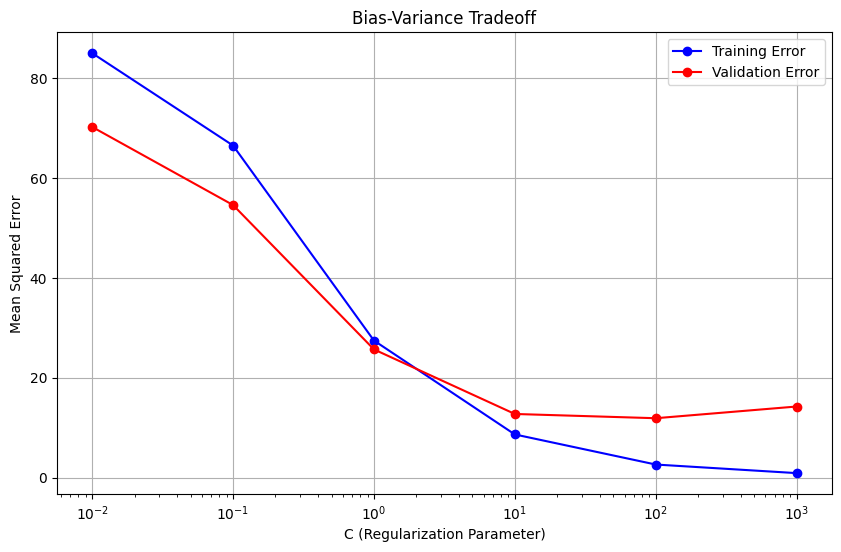

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store training and validation errors
train_errors = []
val_errors = []

# Values of C to explore
C_values = [0.01, 0.1, 1, 10, 100, 1000]

# Compute training and validation errors for each value of C
for C in C_values:
    svr = SVR(C=C, gamma='auto')
    svr.fit(X_train_scaled, y_train)

    train_pred = svr.predict(X_train_scaled)
    val_pred = svr.predict(X_test_scaled)

    train_error = mean_squared_error(y_train, train_pred)
    val_error = mean_squared_error(y_test, val_pred)

    train_errors.append(train_error)
    val_errors.append(val_error)

# Plot the training and validation errors
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, 'o-', label='Training Error', color='blue')
plt.plot(C_values, val_errors, 'o-', label='Validation Error', color='red')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True)
plt.show()


### The plot showcases the bias-variance tradeoff for the SVR model with varying values of the hyperparameter C.



*   For very low values of C, both the training and validation errors are high. This indicates that the model is underfitting the data. The model is too simple and is not capturing the underlying patterns in the data well.
*   As C increases, the training error keeps decreasing, but the validation error starts to increase again after a certain point. This indicates that the model is starting to overfit the training data. The model becomes too complex and starts fitting to the noise in the training data, leading to poor generalization on the validation data.
*   There's a region in the middle where the validation error is at its lowest. This is the optimal level of complexity for the model, where it balances bias and variance to give the best performance on unseen data.


As we can see, a value of C around 100 seems to offer the best tradeoff between bias and variance, which aligns with the results from our grid search.

Therefore, we can conclude that understanding the bias-variance tradeoff is crucial for selecting the right model complexity and avoiding both underfitting and overfitting.




## Predicting on the test set

In [ ]:
# Choosing a row from the testing set
row_index = 4
selected_row = X_test_scaled[row_index]

# Predict the target value for the selected row using the trained SVR model
predicted_value = best_model.predict([selected_row])

# Get the actual target value from the testing set
actual_value = y_test[row_index]

# Compare the predicted value to the actual value
print("Predicted Value:", predicted_value)
print("Actual Value:", actual_value)

Predicted Value: [16.1161282]
Actual Value: 16.1
